In [1]:
import pandas as pd 
import numpy as np
import os
dataset_folder = '../dataset_new'

In [2]:
sensors = ['sensor2', 'sensor3', 'sensor4','sensor7','sensor8','sensor9','sensor11','sensor12','sensor13','sensor14',
           'sensor15','sensor17','sensor20', 'sensor21']

In [3]:
train = []
files = os.listdir(dataset_folder)
train_files = [file for file in files if file.startswith('scaled')]

for file in files: 
    path_to_file = dataset_folder + '/'+file
    df = pd.read_csv(path_to_file, index_col=0) #index_col = 0 perché sennò viene aggiunta la colonna unnamed. 
    train.append(df)

train[0].head()

,unit_number,time_cycle,op_setting1,op_setting2,op_setting3,RUL,sensor2,sensor3,sensor4,sensor6,...,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1.0,1.0,-0.0005,0.0004,100.0,258.0,0.355972,0.370523,0.308580,1.0,...,0.623529,0.204233,0.348571,0.231279,0.642857,0.239116,0.647755,0.272727,0.559524,0.446331
1,1.0,2.0,0.0008,-0.0003,100.0,257.0,0.388759,0.399100,0.309360,1.0,...,0.647059,0.202431,0.308571,0.236882,0.654762,0.278567,0.685659,0.363636,0.488095,0.534836
2,1.0,3.0,-0.0014,-0.0002,100.0,256.0,0.313817,0.353298,0.445398,1.0,...,0.664706,0.241484,0.302857,0.217015,0.636905,0.264526,0.564462,0.272727,0.404762,0.458577
3,1.0,4.0,-0.0020,0.0001,100.0,255.0,0.487119,0.417107,0.237285,1.0,...,0.647059,0.215326,0.314286,0.240448,0.684524,0.245612,0.558909,0.363636,0.470238,0.391966
4,1.0,5.0,0.0016,0.0000,100.0,254.0,0.196721,0.476218,0.321217,1.0,...,0.670588,0.268799,0.262857,0.245033,0.654762,0.252109,0.556736,0.363636,0.577381,0.543371


In [4]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    #Viene calcolato il numero di batch che saranno generati sulla base della grandezza dell'input 
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    
    #Si recupera il numero di features all'interno del dataframe
    num_features = input_data.shape[1]
    '''
    Qui, viene inizializzata una matrice output_data con valori NaN, che rappresenta i dati di output che verranno generati dalla funzione. 
    La matrice è inizialmente creata come una matrice 3D con dimensioni (num_batches, window_length, num_features) per contenere i batch di dati di input.
    '''
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    
    #Verfico che i labels siano stati forniti
    if target_data is None:
        
        #Iteriamo attraverso i batch e copiamo le finestre temporali corrispondenti dai dati di input input_data nella matrice output_data. 
        #L'output sarà quindi una matrice 3D con i batch di dati di input.

        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        #Nel caso in cui i dati siano forniti semplicemente facciamo la stessa cosa per i dati di target
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))] #Differente perché i dati di target sono formattati in altra maniera.
        return output_data, output_targets

In [6]:
#Configurazione

window_length = 30 #Lunghezza delle sequenze
shift = 1
early_rul = 125 #100 è il valore utilizzato comunemente dallo stato dell'arte             
processed_train_data = []
processed_train_targets = []

FD0001 = train[0]
unit_number_col = FD0001['unit_number']
num_train_machines_FD0001 = len(FD0001['unit_number'].unique())
FD0001 = FD0001[sensors]

In [7]:
new_FD0001 = pd.concat([unit_number_col, FD0001], axis= 1 )

In [8]:

for i in np.arange(1, num_train_machines_FD0001 + 1):
    temp_train_data = new_FD0001[new_FD0001['unit_number'] == i].drop(columns = ['unit_number']).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [9]:

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)

Processed trianing data shape:  (21820, 30, 14)
Processed training ruls shape:  (21820,)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(processed_train_data, processed_train_targets, test_size=0.2, random_state=42)

In [11]:
from keras import backend as K 
import tensorflow as tf 
import math 

@tf.function
def custom_loss2(y_true, y_pred):
    alpha = 0.2 # 0.4 per la large !!!
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

@tf.function
def custom_score(y_true, y_pred):
    d_i = y_pred - y_true
    #esponente = tf.where(d_i < 0, 1.0 / (d_i / 13.0), d_i / 10.0)
    sum = tf.reduce_sum(tf.where(d_i < 0, tf.exp(-d_i/13)-1, tf.exp(d_i/10)-1)) #prova
    #sum = tf.reduce_sum(tf.exp(esponente) - 1.0)
    return sum


# def compute_s_score(rul_true, rul_pred):
#     """
#     Both rul_true and rul_pred should be 1D numpy arrays.
#     """
#     diff = rul_pred - rul_true
#     return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

2023-10-19 11:19:26.544964: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-19 11:19:26.545017: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-19 11:19:26.546766: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-19 11:19:26.703355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam


#Replica della rete neurale proposta come "small LSTM"
def createLSTMsmallModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    optimizer = Adam(learning_rate=0.1)
    model.compile(optimizer=optimizer, loss=custom_loss2, metrics = [custom_score] )
    return model


def createLSTMlargeModel(l1Nodes, l2Nodes, l3Nodes, l4Nodes, d1dense , d2dense, input_shape): 
    lstm1 = LSTM(l1Nodes, input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d1 = Dropout(0.2)
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d2 = Dropout(0.2)
    lstm3 = LSTM(l3Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d3 = Dropout(0.2)
    lstm4 = LSTM(l4Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d4 = Dropout(0.2)

    flatten = Flatten()

    dense1 = Dense(d1dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    output_dense = Dense(1,activation='relu', kernel_regularizer=regularizers.l2(0.1))

    layers = [lstm1,d1, lstm2,d2, lstm3, d3, lstm4, d4,flatten,  dense1, dense2, output_dense]
   
    optimizer = Adam(learning_rate=0.01)
    model = Sequential(layers)
    model.compile(optimizer=optimizer, loss=custom_loss2, metrics = [custom_score])
    return model


In [13]:
LSTMlargeModel= createLSTMlargeModel(128, 64, 32, 16, 64, 32, (30,14))

2023-10-19 11:19:44.686886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 11:19:44.723019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 11:19:44.723367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    elif epoch >= 30 and epoch < 60 :
        return 0.001
    elif epoch >= 60 and epoch < 90: 
        return 0.0001
    elif epoch >= 90: 
        return 0.00001
    else: 
        return 0.01; 
    

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model

EPOCHS = 100 

path_large = './models/LSTMlarge/FD0001'
model_checkpoint = ModelCheckpoint(
    path_large,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',

)
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = LSTMlargeModel.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs = 100,
    batch_size = 256,
    use_multiprocessing =True, 
    callbacks=[model_checkpoint, lr_scheduler])



Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100


2023-10-19 11:20:06.260640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-19 11:20:07.987654: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2190002880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-19 11:20:07.987711: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2023-10-19 11:20:07.997825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-19 11:20:08.151573: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 [==============================] - ETA: 0s - loss: 1662.7474 - custom_score: 110176.8984
Epoch 1: val_loss improved from inf to 1428.96301, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 20s 153ms/step - loss: 1662.7474 - custom_score: 110176.8984 - val_loss: 1428.9630 - val_custom_score: 20166.9316 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
66/69 [===========================>..] - ETA: 0s - loss: 1470.7609 - custom_score: 22761.0977
Epoch 2: val_loss did not improve from 1428.96301
69/69 [==============================] - 2s 34ms/step - loss: 1466.7557 - custom_score: 22324.1074 - val_loss: 1439.4669 - val_custom_score: 18776.0918 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
67/69 [============================>.] - ETA: 0s - loss: 1487.8191 - custom_score: 28985.2188
Epoch 3: val_loss did not improve from 1428.96301
69/69 [==============================] - 1s 20ms/step - loss: 1487.2966 - custom_score: 28511.8555 - val_loss: 1441.1643 - val_custom_score: 18817.0586 - lr: 0.0100

Epoch 4: LearningRateScheduler 

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 119ms/step - loss: 1481.4764 - custom_score: 25420.0996 - val_loss: 1419.1680 - val_custom_score: 19897.9277 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 6/100
66/69 [===========================>..] - ETA: 0s - loss: 1455.7085 - custom_score: 22608.1875
Epoch 6: val_loss did not improve from 1419.16797
69/69 [==============================] - 1s 19ms/step - loss: 1453.5466 - custom_score: 22268.0293 - val_loss: 1420.2516 - val_custom_score: 18957.2109 - lr: 0.0100

Epoch 7: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 7/100
67/69 [============================>.] - ETA: 0s - loss: 1454.1938 - custom_score: 22720.0859
Epoch 7: val_loss improved from 1419.16797 to 1417.81104, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 127ms/step - loss: 1451.9482 - custom_score: 22371.6934 - val_loss: 1417.8110 - val_custom_score: 18961.9609 - lr: 0.0100

Epoch 8: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 8/100
69/69 [==============================] - ETA: 0s - loss: 1455.9260 - custom_score: 23130.6523
Epoch 8: val_loss improved from 1417.81104 to 1411.91968, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 124ms/step - loss: 1455.9260 - custom_score: 23130.6523 - val_loss: 1411.9197 - val_custom_score: 19860.5391 - lr: 0.0100

Epoch 9: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 9/100
68/69 [============================>.] - ETA: 0s - loss: 1458.1749 - custom_score: 23809.6367
Epoch 9: val_loss did not improve from 1411.91968
69/69 [==============================] - 1s 15ms/step - loss: 1457.9576 - custom_score: 23551.0703 - val_loss: 1481.5751 - val_custom_score: 33033.2578 - lr: 0.0100

Epoch 10: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 10/100
67/69 [============================>.] - ETA: 0s - loss: 1462.5300 - custom_score: 24276.1484
Epoch 10: val_loss did not improve from 1411.91968
69/69 [==============================] - 1s 18ms/step - loss: 1462.1990 - custom_score: 23935.3594 - val_loss: 1445.1470 - val_custom_score: 27444.7129 - lr: 0.0100

Epoch 11: LearningRateSchedule

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 122ms/step - loss: 1452.2424 - custom_score: 23016.7773 - val_loss: 1408.8688 - val_custom_score: 19787.9258 - lr: 0.0100

Epoch 12: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 12/100
67/69 [============================>.] - ETA: 0s - loss: 1460.9730 - custom_score: 24146.3730
Epoch 12: val_loss did not improve from 1408.86877
69/69 [==============================] - 1s 19ms/step - loss: 1461.8560 - custom_score: 23853.3555 - val_loss: 1455.0476 - val_custom_score: 23247.1699 - lr: 0.0100

Epoch 13: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 13/100
66/69 [===========================>..] - ETA: 0s - loss: 1695.6486 - custom_score: 150957.3906
Epoch 13: val_loss did not improve from 1408.86877
69/69 [==============================] - 1s 15ms/step - loss: 1693.5758 - custom_score: 145576.2031 - val_loss: 1564.5746 - val_custom_score: 22116.5684 - lr: 0.0100

Epoch 14: LearningRateSch

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 127ms/step - loss: 1451.4948 - custom_score: 22771.0430 - val_loss: 1403.0739 - val_custom_score: 19724.5391 - lr: 0.0100

Epoch 25: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 25/100
69/69 [==============================] - ETA: 0s - loss: 1053.5472 - custom_score: 20922.6348
Epoch 25: val_loss improved from 1403.07385 to 622.19452, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 124ms/step - loss: 1053.5472 - custom_score: 20922.6348 - val_loss: 622.1945 - val_custom_score: 5647.1748 - lr: 0.0100

Epoch 26: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 26/100
68/69 [============================>.] - ETA: 0s - loss: 617.8316 - custom_score: 9721.7305
Epoch 26: val_loss improved from 622.19452 to 620.39618, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 10s 143ms/step - loss: 617.4383 - custom_score: 9590.2402 - val_loss: 620.3962 - val_custom_score: 11265.2734 - lr: 0.0100

Epoch 27: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 27/100
68/69 [============================>.] - ETA: 0s - loss: 592.3466 - custom_score: 9321.3789
Epoch 27: val_loss improved from 620.39618 to 570.19867, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 131ms/step - loss: 592.3411 - custom_score: 9200.7920 - val_loss: 570.1987 - val_custom_score: 8741.5713 - lr: 0.0100

Epoch 28: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 28/100
69/69 [==============================] - ETA: 0s - loss: 572.3518 - custom_score: 8700.3271
Epoch 28: val_loss improved from 570.19867 to 473.08945, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 125ms/step - loss: 572.3518 - custom_score: 8700.3271 - val_loss: 473.0894 - val_custom_score: 4688.7207 - lr: 0.0100

Epoch 29: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 29/100
68/69 [============================>.] - ETA: 0s - loss: 446.5233 - custom_score: 4509.5195
Epoch 29: val_loss improved from 473.08945 to 315.81592, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 126ms/step - loss: 446.1324 - custom_score: 4447.1592 - val_loss: 315.8159 - val_custom_score: 1582.2332 - lr: 0.0100

Epoch 30: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 30/100
68/69 [============================>.] - ETA: 0s - loss: 297.0577 - custom_score: 1921.3540
Epoch 30: val_loss improved from 315.81592 to 260.97473, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 126ms/step - loss: 296.9537 - custom_score: 1898.4723 - val_loss: 260.9747 - val_custom_score: 1114.1639 - lr: 0.0100

Epoch 31: LearningRateScheduler setting learning rate to 0.001.
Epoch 31/100
67/69 [============================>.] - ETA: 0s - loss: 241.1803 - custom_score: 1319.8093
Epoch 31: val_loss improved from 260.97473 to 218.26143, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 121ms/step - loss: 240.4888 - custom_score: 1298.6343 - val_loss: 218.2614 - val_custom_score: 1065.4684 - lr: 0.0010

Epoch 32: LearningRateScheduler setting learning rate to 0.001.
Epoch 32/100
68/69 [============================>.] - ETA: 0s - loss: 228.7950 - custom_score: 1235.0988
Epoch 32: val_loss improved from 218.26143 to 210.77959, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 129ms/step - loss: 228.7659 - custom_score: 1220.0266 - val_loss: 210.7796 - val_custom_score: 1037.8918 - lr: 0.0010

Epoch 33: LearningRateScheduler setting learning rate to 0.001.
Epoch 33/100
69/69 [==============================] - ETA: 0s - loss: 222.0109 - custom_score: 1186.7595
Epoch 33: val_loss did not improve from 210.77959
69/69 [==============================] - 1s 17ms/step - loss: 222.0109 - custom_score: 1186.7595 - val_loss: 218.9787 - val_custom_score: 944.0939 - lr: 0.0010

Epoch 34: LearningRateScheduler setting learning rate to 0.001.
Epoch 34/100
66/69 [===========================>..] - ETA: 0s - loss: 217.5965 - custom_score: 1180.2937
Epoch 34: val_loss improved from 210.77959 to 205.48056, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 129ms/step - loss: 217.7168 - custom_score: 1160.8207 - val_loss: 205.4806 - val_custom_score: 1006.3235 - lr: 0.0010

Epoch 35: LearningRateScheduler setting learning rate to 0.001.
Epoch 35/100
69/69 [==============================] - ETA: 0s - loss: 214.8419 - custom_score: 1145.9744
Epoch 35: val_loss improved from 205.48056 to 199.42339, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 120ms/step - loss: 214.8419 - custom_score: 1145.9744 - val_loss: 199.4234 - val_custom_score: 898.7542 - lr: 0.0010

Epoch 36: LearningRateScheduler setting learning rate to 0.001.
Epoch 36/100
67/69 [============================>.] - ETA: 0s - loss: 224.9480 - custom_score: 1373.0526
Epoch 36: val_loss did not improve from 199.42339
69/69 [==============================] - 1s 20ms/step - loss: 224.7543 - custom_score: 1350.9150 - val_loss: 221.6593 - val_custom_score: 980.2693 - lr: 0.0010

Epoch 37: LearningRateScheduler setting learning rate to 0.001.
Epoch 37/100
66/69 [===========================>..] - ETA: 0s - loss: 218.1204 - custom_score: 1199.0343
Epoch 37: val_loss improved from 199.42339 to 197.18076, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 136ms/step - loss: 218.4515 - custom_score: 1190.9459 - val_loss: 197.1808 - val_custom_score: 864.1204 - lr: 0.0010

Epoch 38: LearningRateScheduler setting learning rate to 0.001.
Epoch 38/100
69/69 [==============================] - ETA: 0s - loss: 205.5245 - custom_score: 1089.7670
Epoch 38: val_loss improved from 197.18076 to 191.08119, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 130ms/step - loss: 205.5245 - custom_score: 1089.7670 - val_loss: 191.0812 - val_custom_score: 913.0640 - lr: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.001.
Epoch 39/100
68/69 [============================>.] - ETA: 0s - loss: 202.8858 - custom_score: 1088.9291
Epoch 39: val_loss improved from 191.08119 to 187.78586, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 132ms/step - loss: 203.0832 - custom_score: 1081.5562 - val_loss: 187.7859 - val_custom_score: 831.0754 - lr: 0.0010

Epoch 40: LearningRateScheduler setting learning rate to 0.001.
Epoch 40/100
68/69 [============================>.] - ETA: 0s - loss: 199.1071 - custom_score: 1069.0450
Epoch 40: val_loss did not improve from 187.78586
69/69 [==============================] - 1s 19ms/step - loss: 199.0999 - custom_score: 1057.2904 - val_loss: 191.0891 - val_custom_score: 754.2925 - lr: 0.0010

Epoch 41: LearningRateScheduler setting learning rate to 0.001.
Epoch 41/100
69/69 [==============================] - ETA: 0s - loss: 196.6527 - custom_score: 1033.1892
Epoch 41: val_loss improved from 187.78586 to 181.24304, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 119ms/step - loss: 196.6527 - custom_score: 1033.1892 - val_loss: 181.2430 - val_custom_score: 803.8376 - lr: 0.0010

Epoch 42: LearningRateScheduler setting learning rate to 0.001.
Epoch 42/100
68/69 [============================>.] - ETA: 0s - loss: 191.8452 - custom_score: 1005.1566
Epoch 42: val_loss improved from 181.24304 to 180.33641, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 119ms/step - loss: 191.7660 - custom_score: 992.1844 - val_loss: 180.3364 - val_custom_score: 857.6266 - lr: 0.0010

Epoch 43: LearningRateScheduler setting learning rate to 0.001.
Epoch 43/100
68/69 [============================>.] - ETA: 0s - loss: 186.3844 - custom_score: 966.2625
Epoch 43: val_loss improved from 180.33641 to 178.15565, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 120ms/step - loss: 186.3349 - custom_score: 954.0882 - val_loss: 178.1557 - val_custom_score: 749.7919 - lr: 0.0010

Epoch 44: LearningRateScheduler setting learning rate to 0.001.
Epoch 44/100
68/69 [============================>.] - ETA: 0s - loss: 183.2113 - custom_score: 955.8118
Epoch 44: val_loss improved from 178.15565 to 174.59828, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 119ms/step - loss: 183.1204 - custom_score: 943.6382 - val_loss: 174.5983 - val_custom_score: 725.0090 - lr: 0.0010

Epoch 45: LearningRateScheduler setting learning rate to 0.001.
Epoch 45/100
66/69 [===========================>..] - ETA: 0s - loss: 180.6753 - custom_score: 927.0301
Epoch 45: val_loss improved from 174.59828 to 166.23938, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 130ms/step - loss: 180.7310 - custom_score: 916.5135 - val_loss: 166.2394 - val_custom_score: 739.5641 - lr: 0.0010

Epoch 46: LearningRateScheduler setting learning rate to 0.001.
Epoch 46/100
65/69 [===========================>..] - ETA: 0s - loss: 174.4173 - custom_score: 884.7485
Epoch 46: val_loss improved from 166.23938 to 164.73450, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 8s 125ms/step - loss: 174.1629 - custom_score: 869.0346 - val_loss: 164.7345 - val_custom_score: 670.3531 - lr: 0.0010

Epoch 47: LearningRateScheduler setting learning rate to 0.001.
Epoch 47/100
69/69 [==============================] - ETA: 0s - loss: 173.0195 - custom_score: 850.0741
Epoch 47: val_loss did not improve from 164.73450
69/69 [==============================] - 1s 16ms/step - loss: 173.0195 - custom_score: 850.0741 - val_loss: 165.4695 - val_custom_score: 812.0732 - lr: 0.0010

Epoch 48: LearningRateScheduler setting learning rate to 0.001.
Epoch 48/100
69/69 [==============================] - ETA: 0s - loss: 169.6974 - custom_score: 837.1624
Epoch 48: val_loss did not improve from 164.73450
69/69 [==============================] - 1s 15ms/step - loss: 169.6974 - custom_score: 837.1624 - val_loss: 173.8321 - val_custom_score: 659.3032 - lr: 0.0010

Epoch 49: LearningRateScheduler setting learning rate to 0.001.
Epoch 49/100
67/69 

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 132ms/step - loss: 162.9735 - custom_score: 792.4261 - val_loss: 155.0414 - val_custom_score: 729.3105 - lr: 0.0010

Epoch 51: LearningRateScheduler setting learning rate to 0.001.
Epoch 51/100
69/69 [==============================] - ETA: 0s - loss: 159.0487 - custom_score: 767.4807
Epoch 51: val_loss did not improve from 155.04144
69/69 [==============================] - 1s 18ms/step - loss: 159.0487 - custom_score: 767.4807 - val_loss: 165.5046 - val_custom_score: 606.9156 - lr: 0.0010

Epoch 52: LearningRateScheduler setting learning rate to 0.001.
Epoch 52/100
69/69 [==============================] - ETA: 0s - loss: 157.5177 - custom_score: 768.6660
Epoch 52: val_loss improved from 155.04144 to 143.68361, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 10s 140ms/step - loss: 157.5177 - custom_score: 768.6660 - val_loss: 143.6836 - val_custom_score: 637.4396 - lr: 0.0010

Epoch 53: LearningRateScheduler setting learning rate to 0.001.
Epoch 53/100
68/69 [============================>.] - ETA: 0s - loss: 151.4632 - custom_score: 721.7407
Epoch 53: val_loss did not improve from 143.68361
69/69 [==============================] - 1s 20ms/step - loss: 151.5112 - custom_score: 713.6021 - val_loss: 150.3294 - val_custom_score: 730.9227 - lr: 0.0010

Epoch 54: LearningRateScheduler setting learning rate to 0.001.
Epoch 54/100
69/69 [==============================] - ETA: 0s - loss: 152.6085 - custom_score: 738.9099
Epoch 54: val_loss improved from 143.68361 to 138.11787, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 131ms/step - loss: 152.6085 - custom_score: 738.9099 - val_loss: 138.1179 - val_custom_score: 591.3653 - lr: 0.0010

Epoch 55: LearningRateScheduler setting learning rate to 0.001.
Epoch 55/100
69/69 [==============================] - ETA: 0s - loss: 146.9249 - custom_score: 694.5196
Epoch 55: val_loss improved from 138.11787 to 137.93790, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 137ms/step - loss: 146.9249 - custom_score: 694.5196 - val_loss: 137.9379 - val_custom_score: 576.4378 - lr: 0.0010

Epoch 56: LearningRateScheduler setting learning rate to 0.001.
Epoch 56/100
69/69 [==============================] - ETA: 0s - loss: 144.3357 - custom_score: 668.8117
Epoch 56: val_loss improved from 137.93790 to 137.45656, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 10s 143ms/step - loss: 144.3357 - custom_score: 668.8117 - val_loss: 137.4566 - val_custom_score: 670.9922 - lr: 0.0010

Epoch 57: LearningRateScheduler setting learning rate to 0.001.
Epoch 57/100
68/69 [============================>.] - ETA: 0s - loss: 141.7703 - custom_score: 665.5248
Epoch 57: val_loss improved from 137.45656 to 133.17987, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 139ms/step - loss: 141.8373 - custom_score: 657.6480 - val_loss: 133.1799 - val_custom_score: 559.6161 - lr: 0.0010

Epoch 58: LearningRateScheduler setting learning rate to 0.001.
Epoch 58/100
66/69 [===========================>..] - ETA: 0s - loss: 141.1756 - custom_score: 666.9775
Epoch 58: val_loss improved from 133.17987 to 127.93224, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 133ms/step - loss: 141.3088 - custom_score: 659.3211 - val_loss: 127.9322 - val_custom_score: 516.3660 - lr: 0.0010

Epoch 59: LearningRateScheduler setting learning rate to 0.001.
Epoch 59/100
66/69 [===========================>..] - ETA: 0s - loss: 139.4653 - custom_score: 658.4194
Epoch 59: val_loss did not improve from 127.93224
69/69 [==============================] - 1s 16ms/step - loss: 139.6699 - custom_score: 650.3297 - val_loss: 132.4682 - val_custom_score: 588.0247 - lr: 0.0010

Epoch 60: LearningRateScheduler setting learning rate to 0.001.
Epoch 60/100
67/69 [============================>.] - ETA: 0s - loss: 135.6484 - custom_score: 628.5605
Epoch 60: val_loss did not improve from 127.93224
69/69 [==============================] - 1s 18ms/step - loss: 135.6228 - custom_score: 622.0897 - val_loss: 130.3250 - val_custom_score: 554.5386 - lr: 0.0010

Epoch 61: LearningRateScheduler setting learning rate to 0.0001.
Epoch 61/100
69/69

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 132ms/step - loss: 130.7970 - custom_score: 597.1920 - val_loss: 124.4785 - val_custom_score: 494.4490 - lr: 1.0000e-04

Epoch 62: LearningRateScheduler setting learning rate to 0.0001.
Epoch 62/100
68/69 [============================>.] - ETA: 0s - loss: 129.7696 - custom_score: 594.5858
Epoch 62: val_loss improved from 124.47848 to 123.22479, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 130ms/step - loss: 129.9101 - custom_score: 589.0786 - val_loss: 123.2248 - val_custom_score: 496.0710 - lr: 1.0000e-04

Epoch 63: LearningRateScheduler setting learning rate to 0.0001.
Epoch 63/100
67/69 [============================>.] - ETA: 0s - loss: 129.1573 - custom_score: 589.4236
Epoch 63: val_loss did not improve from 123.22479
69/69 [==============================] - 1s 20ms/step - loss: 129.1407 - custom_score: 582.0206 - val_loss: 124.2399 - val_custom_score: 499.5783 - lr: 1.0000e-04

Epoch 64: LearningRateScheduler setting learning rate to 0.0001.
Epoch 64/100
68/69 [============================>.] - ETA: 0s - loss: 128.3140 - custom_score: 579.7493
Epoch 64: val_loss improved from 123.22479 to 123.19971, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 131ms/step - loss: 128.3466 - custom_score: 573.4175 - val_loss: 123.1997 - val_custom_score: 503.4240 - lr: 1.0000e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.0001.
Epoch 65/100
67/69 [============================>.] - ETA: 0s - loss: 127.4463 - custom_score: 583.2321
Epoch 65: val_loss did not improve from 123.19971
69/69 [==============================] - 1s 20ms/step - loss: 127.6352 - custom_score: 577.3253 - val_loss: 124.9628 - val_custom_score: 479.3465 - lr: 1.0000e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.0001.
Epoch 66/100
66/69 [===========================>..] - ETA: 0s - loss: 128.2523 - custom_score: 581.7206
Epoch 66: val_loss did not improve from 123.19971
69/69 [==============================] - 1s 18ms/step - loss: 128.1322 - custom_score: 574.0488 - val_loss: 123.6860 - val_custom_score: 540.7022 - lr: 1.0000e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.0001.
Epoc

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 10s 143ms/step - loss: 127.3886 - custom_score: 574.7300 - val_loss: 122.8316 - val_custom_score: 499.4330 - lr: 1.0000e-04

Epoch 68: LearningRateScheduler setting learning rate to 0.0001.
Epoch 68/100
66/69 [===========================>..] - ETA: 0s - loss: 126.8527 - custom_score: 578.3419
Epoch 68: val_loss improved from 122.83160 to 122.13767, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 10s 154ms/step - loss: 126.5433 - custom_score: 568.8124 - val_loss: 122.1377 - val_custom_score: 505.0875 - lr: 1.0000e-04

Epoch 69: LearningRateScheduler setting learning rate to 0.0001.
Epoch 69/100
69/69 [==============================] - ETA: 0s - loss: 126.3652 - custom_score: 566.1642
Epoch 69: val_loss improved from 122.13767 to 121.91312, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 135ms/step - loss: 126.3652 - custom_score: 566.1642 - val_loss: 121.9131 - val_custom_score: 502.5450 - lr: 1.0000e-04

Epoch 70: LearningRateScheduler setting learning rate to 0.0001.
Epoch 70/100
68/69 [============================>.] - ETA: 0s - loss: 126.5434 - custom_score: 574.4071
Epoch 70: val_loss improved from 121.91312 to 121.55631, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 9s 134ms/step - loss: 126.5323 - custom_score: 567.5033 - val_loss: 121.5563 - val_custom_score: 517.3710 - lr: 1.0000e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.0001.
Epoch 71/100
68/69 [============================>.] - ETA: 0s - loss: 127.2307 - custom_score: 581.1667
Epoch 71: val_loss did not improve from 121.55631
69/69 [==============================] - 1s 19ms/step - loss: 127.3019 - custom_score: 574.5351 - val_loss: 122.2357 - val_custom_score: 490.2953 - lr: 1.0000e-04

Epoch 72: LearningRateScheduler setting learning rate to 0.0001.
Epoch 72/100
67/69 [============================>.] - ETA: 0s - loss: 126.9294 - custom_score: 582.1826
Epoch 72: val_loss did not improve from 121.55631
69/69 [==============================] - 1s 20ms/step - loss: 126.7035 - custom_score: 574.2570 - val_loss: 122.4756 - val_custom_score: 487.1165 - lr: 1.0000e-04

Epoch 73: LearningRateScheduler setting learning rate to 0.0001.
Epoc

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 155ms/step - loss: 125.4929 - custom_score: 563.7820 - val_loss: 121.1575 - val_custom_score: 485.9915 - lr: 1.0000e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.0001.
Epoch 75/100
66/69 [===========================>..] - ETA: 0s - loss: 124.8191 - custom_score: 563.7870
Epoch 75: val_loss improved from 121.15754 to 121.09184, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 10s 150ms/step - loss: 125.2564 - custom_score: 558.8066 - val_loss: 121.0918 - val_custom_score: 482.8752 - lr: 1.0000e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.0001.
Epoch 76/100
69/69 [==============================] - ETA: 0s - loss: 124.9826 - custom_score: 558.6718
Epoch 76: val_loss improved from 121.09184 to 120.36259, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 160ms/step - loss: 124.9826 - custom_score: 558.6718 - val_loss: 120.3626 - val_custom_score: 492.6225 - lr: 1.0000e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.0001.
Epoch 77/100
68/69 [============================>.] - ETA: 0s - loss: 124.3585 - custom_score: 564.8532
Epoch 77: val_loss did not improve from 120.36259
69/69 [==============================] - 1s 19ms/step - loss: 124.3016 - custom_score: 557.8038 - val_loss: 121.0409 - val_custom_score: 504.0172 - lr: 1.0000e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0001.
Epoch 78/100
68/69 [============================>.] - ETA: 0s - loss: 124.3555 - custom_score: 562.3260
Epoch 78: val_loss improved from 120.36259 to 119.76814, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 198ms/step - loss: 124.2952 - custom_score: 556.4766 - val_loss: 119.7681 - val_custom_score: 487.4095 - lr: 1.0000e-04

Epoch 79: LearningRateScheduler setting learning rate to 0.0001.
Epoch 79/100
67/69 [============================>.] - ETA: 0s - loss: 125.3216 - custom_score: 567.7717
Epoch 79: val_loss did not improve from 119.76814
69/69 [==============================] - 2s 25ms/step - loss: 125.3020 - custom_score: 560.1813 - val_loss: 119.8670 - val_custom_score: 490.0091 - lr: 1.0000e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.0001.
Epoch 80/100
67/69 [============================>.] - ETA: 0s - loss: 125.1758 - custom_score: 571.3754
Epoch 80: val_loss did not improve from 119.76814
69/69 [==============================] - 2s 28ms/step - loss: 125.1380 - custom_score: 564.1731 - val_loss: 120.9616 - val_custom_score: 491.8714 - lr: 1.0000e-04

Epoch 81: LearningRateScheduler setting learning rate to 0.0001.
Epo

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 16s 231ms/step - loss: 123.2197 - custom_score: 553.4184 - val_loss: 119.5938 - val_custom_score: 490.4974 - lr: 1.0000e-04

Epoch 83: LearningRateScheduler setting learning rate to 0.0001.
Epoch 83/100
68/69 [============================>.] - ETA: 0s - loss: 124.0055 - custom_score: 564.0377
Epoch 83: val_loss did not improve from 119.59383
69/69 [==============================] - 1s 18ms/step - loss: 124.0203 - custom_score: 557.1664 - val_loss: 120.5195 - val_custom_score: 466.0889 - lr: 1.0000e-04

Epoch 84: LearningRateScheduler setting learning rate to 0.0001.
Epoch 84/100
67/69 [============================>.] - ETA: 0s - loss: 124.6398 - custom_score: 567.0490
Epoch 84: val_loss did not improve from 119.59383
69/69 [==============================] - 1s 22ms/step - loss: 124.8079 - custom_score: 560.0756 - val_loss: 122.5217 - val_custom_score: 465.6429 - lr: 1.0000e-04

Epoch 85: LearningRateScheduler setting learning rate to 0.0001.
Epo

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 13s 197ms/step - loss: 123.6785 - custom_score: 554.9755 - val_loss: 119.5627 - val_custom_score: 491.2326 - lr: 1.0000e-04

Epoch 86: LearningRateScheduler setting learning rate to 0.0001.
Epoch 86/100
67/69 [============================>.] - ETA: 0s - loss: 123.1109 - custom_score: 565.4742
Epoch 86: val_loss improved from 119.56271 to 119.21518, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 15s 224ms/step - loss: 123.0416 - custom_score: 558.6197 - val_loss: 119.2152 - val_custom_score: 465.5497 - lr: 1.0000e-04

Epoch 87: LearningRateScheduler setting learning rate to 0.0001.
Epoch 87/100
66/69 [===========================>..] - ETA: 0s - loss: 123.5603 - custom_score: 554.2676
Epoch 87: val_loss improved from 119.21518 to 118.69395, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 16s 232ms/step - loss: 123.4605 - custom_score: 548.8367 - val_loss: 118.6939 - val_custom_score: 496.5817 - lr: 1.0000e-04

Epoch 88: LearningRateScheduler setting learning rate to 0.0001.
Epoch 88/100
67/69 [============================>.] - ETA: 0s - loss: 122.8472 - custom_score: 556.2842
Epoch 88: val_loss did not improve from 118.69395
69/69 [==============================] - 1s 19ms/step - loss: 122.6705 - custom_score: 548.6665 - val_loss: 118.8364 - val_custom_score: 470.2801 - lr: 1.0000e-04

Epoch 89: LearningRateScheduler setting learning rate to 0.0001.
Epoch 89/100
69/69 [==============================] - ETA: 0s - loss: 121.5767 - custom_score: 536.5872
Epoch 89: val_loss improved from 118.69395 to 118.15046, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 12s 177ms/step - loss: 121.5767 - custom_score: 536.5872 - val_loss: 118.1505 - val_custom_score: 503.7323 - lr: 1.0000e-04

Epoch 90: LearningRateScheduler setting learning rate to 0.0001.
Epoch 90/100
67/69 [============================>.] - ETA: 0s - loss: 122.3733 - custom_score: 557.3890
Epoch 90: val_loss did not improve from 118.15046
69/69 [==============================] - 1s 20ms/step - loss: 122.7214 - custom_score: 552.3196 - val_loss: 119.2860 - val_custom_score: 464.7570 - lr: 1.0000e-04

Epoch 91: LearningRateScheduler setting learning rate to 1e-05.
Epoch 91/100
68/69 [============================>.] - ETA: 0s - loss: 121.4480 - custom_score: 538.6243
Epoch 91: val_loss improved from 118.15046 to 117.86666, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 10s 152ms/step - loss: 121.3244 - custom_score: 531.6702 - val_loss: 117.8667 - val_custom_score: 479.6604 - lr: 1.0000e-05

Epoch 92: LearningRateScheduler setting learning rate to 1e-05.
Epoch 92/100
67/69 [============================>.] - ETA: 0s - loss: 120.7462 - custom_score: 542.0930
Epoch 92: val_loss did not improve from 117.86666
69/69 [==============================] - 1s 20ms/step - loss: 120.9572 - custom_score: 537.2055 - val_loss: 117.9003 - val_custom_score: 472.5009 - lr: 1.0000e-05

Epoch 93: LearningRateScheduler setting learning rate to 1e-05.
Epoch 93/100
69/69 [==============================] - ETA: 0s - loss: 121.3489 - custom_score: 537.2288
Epoch 93: val_loss did not improve from 117.86666
69/69 [==============================] - 1s 20ms/step - loss: 121.3489 - custom_score: 537.2288 - val_loss: 117.9311 - val_custom_score: 472.6315 - lr: 1.0000e-05

Epoch 94: LearningRateScheduler setting learning rate to 1e-05.
Epoch 

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 162ms/step - loss: 121.2143 - custom_score: 549.4052 - val_loss: 117.8488 - val_custom_score: 473.2830 - lr: 1.0000e-05

Epoch 95: LearningRateScheduler setting learning rate to 1e-05.
Epoch 95/100
69/69 [==============================] - ETA: 0s - loss: 121.5011 - custom_score: 542.9543
Epoch 95: val_loss improved from 117.84879 to 117.71962, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 10s 146ms/step - loss: 121.5011 - custom_score: 542.9543 - val_loss: 117.7196 - val_custom_score: 476.0805 - lr: 1.0000e-05

Epoch 96: LearningRateScheduler setting learning rate to 1e-05.
Epoch 96/100
68/69 [============================>.] - ETA: 0s - loss: 121.6562 - custom_score: 554.9761
Epoch 96: val_loss did not improve from 117.71962
69/69 [==============================] - 1s 20ms/step - loss: 121.6779 - custom_score: 548.5420 - val_loss: 117.8731 - val_custom_score: 476.3008 - lr: 1.0000e-05

Epoch 97: LearningRateScheduler setting learning rate to 1e-05.
Epoch 97/100
69/69 [==============================] - ETA: 0s - loss: 122.0813 - custom_score: 548.9241
Epoch 97: val_loss did not improve from 117.71962
69/69 [==============================] - 1s 21ms/step - loss: 122.0813 - custom_score: 548.9241 - val_loss: 117.7701 - val_custom_score: 472.0566 - lr: 1.0000e-05

Epoch 98: LearningRateScheduler setting learning rate to 1e-05.
Epoch 

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 155ms/step - loss: 122.5491 - custom_score: 554.2312 - val_loss: 117.4755 - val_custom_score: 474.2396 - lr: 1.0000e-05

Epoch 99: LearningRateScheduler setting learning rate to 1e-05.
Epoch 99/100
67/69 [============================>.] - ETA: 0s - loss: 121.2188 - custom_score: 548.3793
Epoch 99: val_loss did not improve from 117.47546
69/69 [==============================] - 1s 19ms/step - loss: 121.2842 - custom_score: 541.5803 - val_loss: 117.7687 - val_custom_score: 471.7735 - lr: 1.0000e-05

Epoch 100: LearningRateScheduler setting learning rate to 1e-05.
Epoch 100/100
68/69 [============================>.] - ETA: 0s - loss: 121.1835 - custom_score: 549.7436
Epoch 100: val_loss did not improve from 117.47546
69/69 [==============================] - 1s 20ms/step - loss: 121.3460 - custom_score: 544.8052 - val_loss: 117.7344 - val_custom_score: 473.2188 - lr: 1.0000e-05


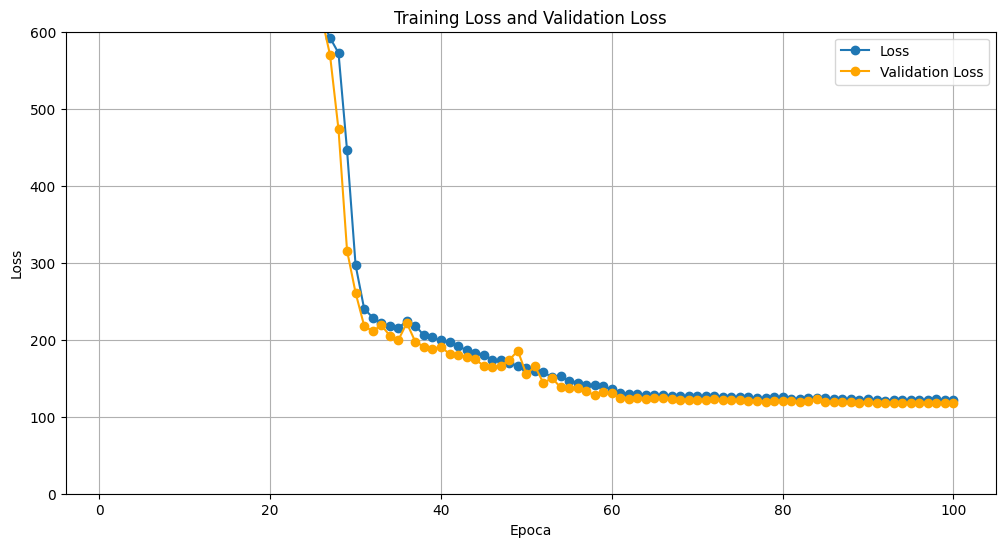

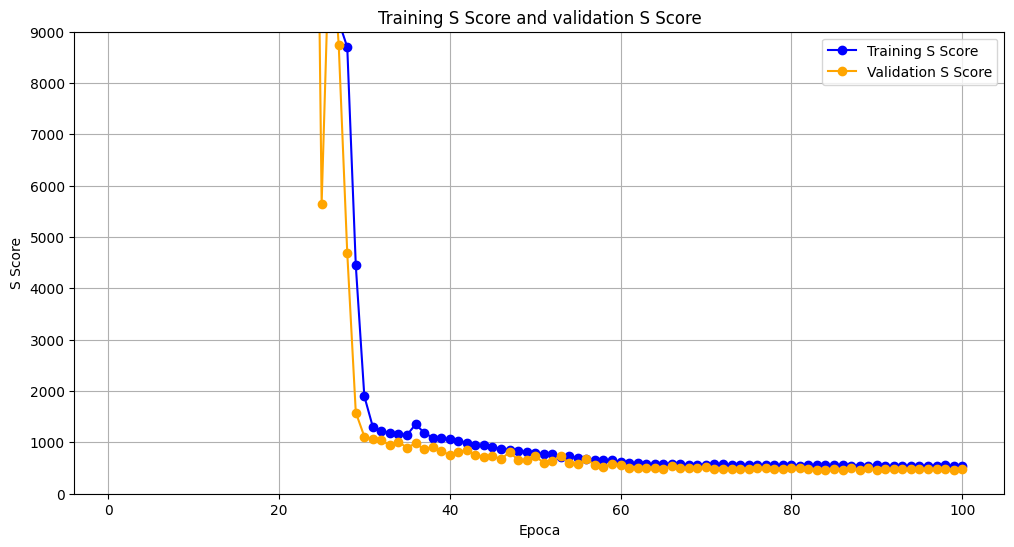

In [16]:
import matplotlib.pyplot as plt
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']


custom_score_values = history.history['custom_score']  
custom_score_validation_values = history.history['val_custom_score']


# Plot della loss function
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0, 600)
plt.legend()
plt.grid(True)
plt.show()

# Plot della custom score
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(0, 9000)
plt.legend()
plt.grid(True)
plt.show()


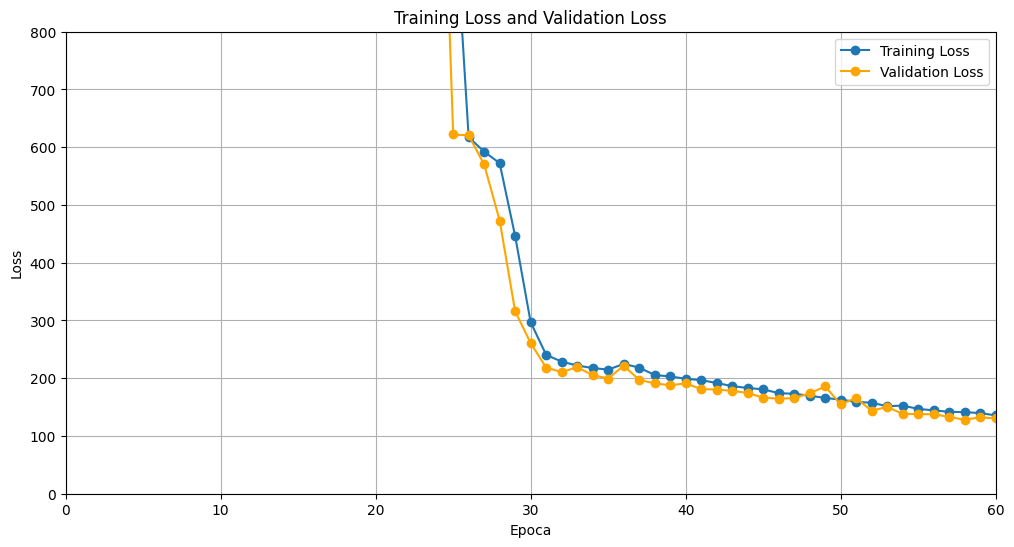

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0,800)
plt.xlim(0,60)
plt.legend()
plt.grid(True)
plt.show()


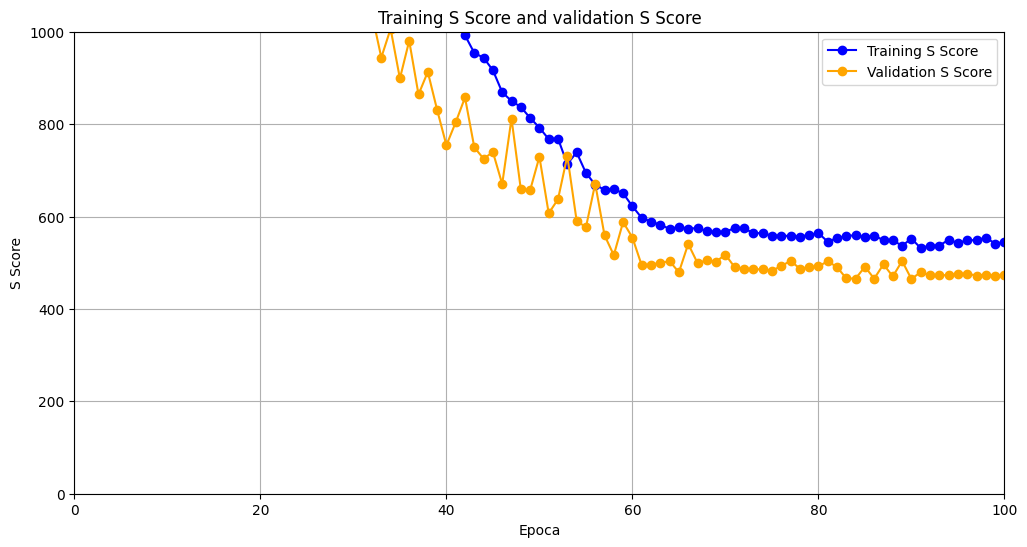

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(0,1000)
plt.xlim(0,100)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
### FUNZIONA
MODEL_DIR = '/home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001'
run_model = tf.function(lambda x: LSTMlargeModel(x))
BATCH_SIZE = 1
STEPS = 30
INPUT_SIZE = 14

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], LSTMlargeModel.inputs[0].dtype)
)
converter = tf.lite.TFLiteConverter.from_keras_model(LSTMlargeModel)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]


LSTMlargeModel.save(MODEL_DIR, save_format="tf", signatures = concrete_func )

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

with open("large_lstm_fixed_batch_1.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001/assets
2023-10-19 11:32:47.250775: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-19 11:32:47.250815: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-19 11:32:47.257662: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001
2023-10-19 11:32:47.281587: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-19 11:32:47.281629: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001
2023-10-19 11:32:47.325241: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
